# Flipkart Review Sentiment Analysis

## Loading the Data

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import make_scorer, f1_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [50]:
df = pd.read_csv("data.csv")

In [51]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [52]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

## Exploratory Data Analysis

In [53]:
df.shape

(8518, 8)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [55]:
df.isna().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [56]:
df = df.dropna(subset=['Review text'])

In [57]:
df['Ratings'].value_counts()

Ratings
5    5079
4    1744
1     766
3     615
2     306
Name: count, dtype: int64

<Axes: xlabel='Ratings', ylabel='count'>

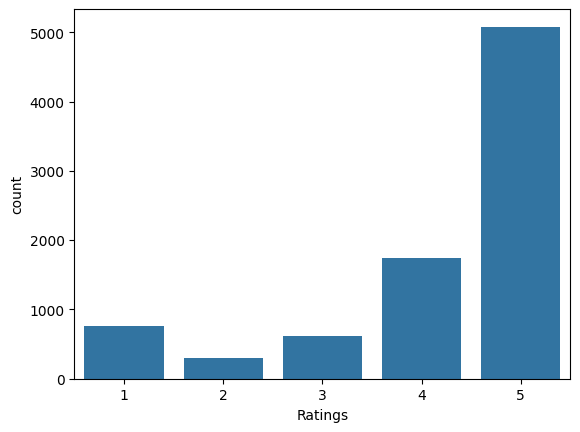

In [58]:
sns.countplot(x='Ratings', data=df)

In [59]:
df['Ratings'] = df['Ratings'].replace({3: 'Positive', 4: 'Positive', 5: 'Positive', 1: 'Negative', 2: 'Negative'})

<Axes: xlabel='Ratings', ylabel='count'>

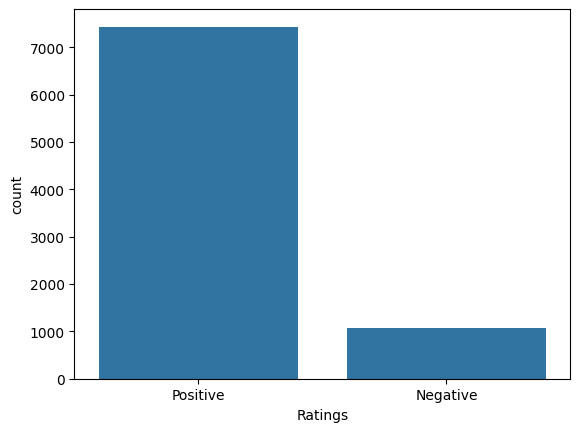

In [60]:
sns.countplot(x='Ratings', data=df)

In [61]:
df = df[['Review text', 'Ratings']]
df.shape

(8510, 2)

## Identify Input and Output

In [62]:
X = df['Review text']
y = df['Ratings']
print(X.shape, y.shape)

(8510,) (8510,)


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6382,) (6382,)
(2128,) (2128,)


## Data Preprocessing on train data (X_train)

In [64]:
lemmatizer = WordNetLemmatizer()

In [65]:
# Download the punctuations
nltk.download('punkt')

# Download the stop words corpus
nltk.download('stopwords')

# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [66]:
def clean(raw_text): 
    text = re.sub("[^a-zA-Z]", " ", raw_text)
    
    text = text.lower()

    tokens = word_tokenize(text)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [67]:
# instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

CPU times: total: 3.62 s
Wall time: 4.98 s
(6382, 2599)


## Data Preprocessing on test data (X_test)

In [68]:
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(2128, 2599)


## Building a Model (i.e. Train the classifier)

### Naive Bayes

In [69]:
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: total: 31.2 ms
Wall time: 28.7 ms


MultinomialNB()

### Decision Tree

In [70]:
dt = DecisionTreeClassifier()
%time dt.fit(X_train_dtm, y_train)

CPU times: total: 312 ms
Wall time: 375 ms


DecisionTreeClassifier()

### Logistic Regression

In [71]:
lr = LogisticRegression()
%time lr.fit(X_train_dtm,y_train)

CPU times: total: 31.2 ms
Wall time: 49.4 ms


LogisticRegression()

## Evaluating on Train Data

### Naive Bayes

In [72]:
y_train_pred = nb.predict(X_train_dtm)

print("Accuracy : ", accuracy_score(y_train, y_train_pred))
print("F1 Score : ",f1_score(y_train, y_train_pred, pos_label='Positive'))

Accuracy :  0.9356001253525541
F1 Score :  0.9637598095406049


In [73]:
confusion_matrix(y_train, y_train_pred)

array([[ 506,  311],
       [ 100, 5465]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

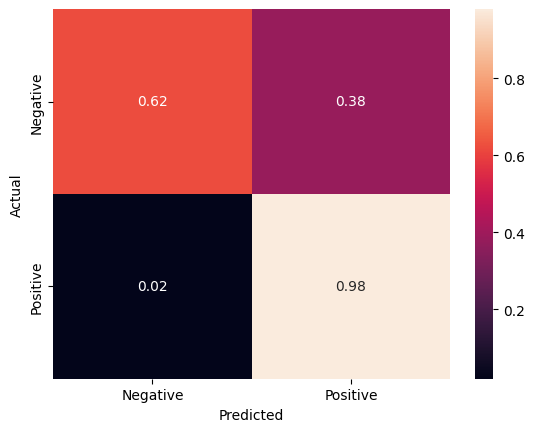

In [74]:
cm = confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision Tree

In [75]:
y_train_pred = dt.predict(X_train_dtm)

print("Accuracy : ", accuracy_score(y_train, y_train_pred))
print("F1 Score : ",f1_score(y_train, y_train_pred, pos_label='Positive'))

Accuracy :  0.9804136634283923
F1 Score :  0.9887761515668493


In [76]:
confusion_matrix(y_train, y_train_pred)

array([[ 751,   66],
       [  59, 5506]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

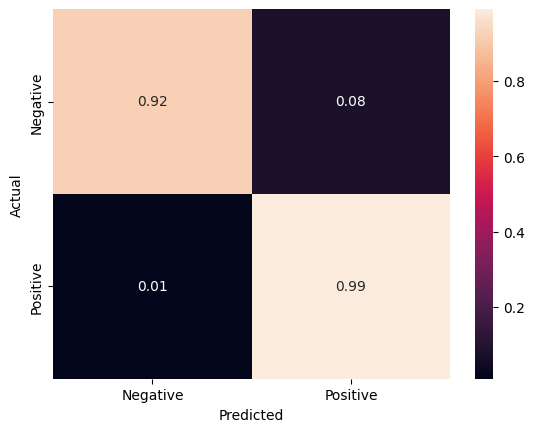

In [77]:
cm = confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Logistic Regression

In [78]:
y_train_pred = lr.predict(X_train_dtm)

print("Accuracy : ", accuracy_score(y_train, y_train_pred))
print("F1 Score : ",f1_score(y_train, y_train_pred, pos_label='Positive'))

Accuracy :  0.9465684738326543
F1 Score :  0.9700377822686934


In [79]:
confusion_matrix(y_train, y_train_pred)

array([[ 521,  296],
       [  45, 5520]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

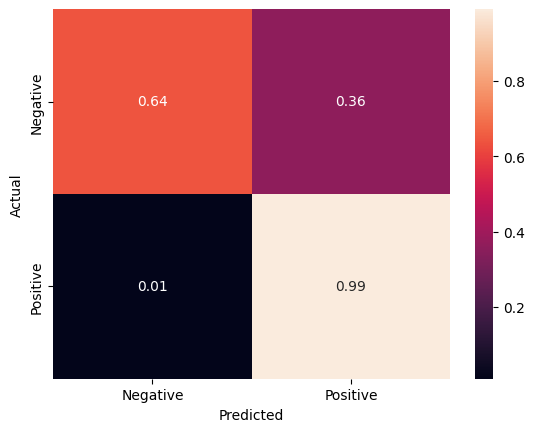

In [80]:
cm = confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

- Naive Bayes F1 Score :  0.9637598095406049
- Decision Tree F1 Score :  0.9887761515668492
- Logistic Regression F1 Score :  0.969872639437857

On the Training Data Decision Tree as higher F1 Score

## Evaluate on Test Data

### Naive Bayes

In [81]:
y_test_pred = nb.predict(X_test_dtm)

print("Accuracy : ",accuracy_score(y_test, y_test_pred))
print("F1 Score : ",f1_score(y_test, y_test_pred, pos_label='Positive'))

Accuracy :  0.9163533834586466
F1 Score :  0.9535732916014606


Text(0.5, 23.52222222222222, 'Predicted')

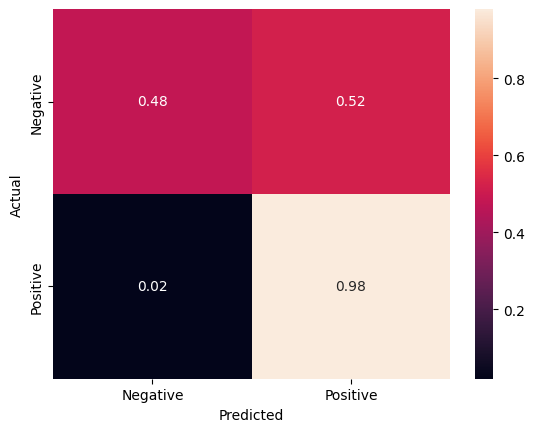

In [82]:
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision Tree

In [83]:
y_test_pred = dt.predict(X_test_dtm)

print("Accuracy : ",accuracy_score(y_test, y_test_pred))
print("F1 Score : ",f1_score(y_test, y_test_pred, pos_label='Positive'))

Accuracy :  0.8909774436090225
F1 Score :  0.9382321618743344


Text(0.5, 23.52222222222222, 'Predicted')

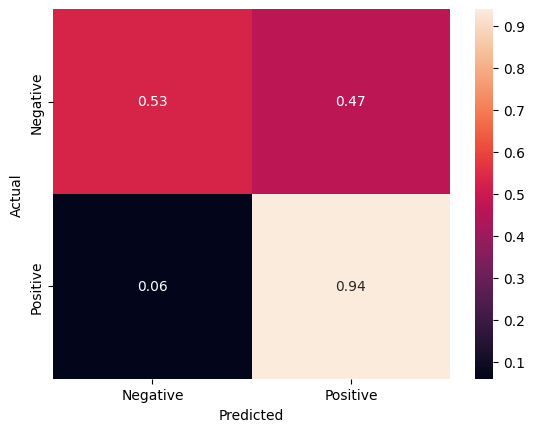

In [84]:
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Logistic Regression

In [85]:
y_test_pred = lr.predict(X_test_dtm)

print("Accuracy : ",accuracy_score(y_test, y_test_pred))
print("F1 Score : ",f1_score(y_test, y_test_pred, pos_label='Positive'))

Accuracy :  0.918703007518797
F1 Score :  0.9550065019505852


Text(0.5, 23.52222222222222, 'Predicted')

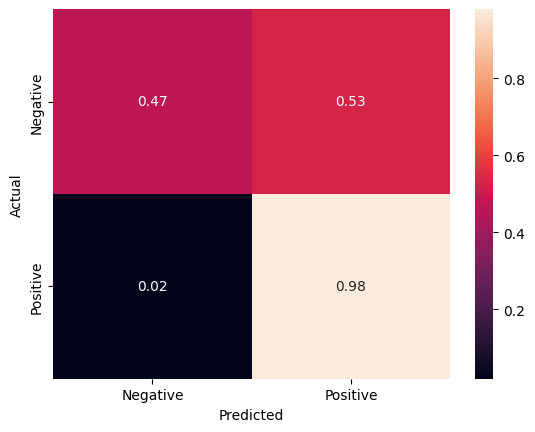

In [86]:
cm = confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Hyper parameter tuning & Experiment Tracking and Model Registry

In [88]:
import joblib
from joblib import Memory

import os
import warnings

warnings.filterwarnings('ignore')

In [46]:
import mlflow

In [94]:
mlflow.set_experiment("Review_Sentiment_Prediction")

2024/03/27 00:45:32 INFO mlflow.tracking.fluent: Experiment with name 'Review_Sentiment_Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///h:/Courses/python_DS/Innomatics%20Internship/Sentiment%20Analysis%20of%20Flipkart%20Reviews%20-%20MLOPS%20and%20Orchestration/mlruns/862320923495261754', creation_time=1711480532080, experiment_id='862320923495261754', last_update_time=1711480532080, lifecycle_stage='active', name='Review_Sentiment_Prediction', tags={}>

In [95]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

In [96]:
# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='accuracy', 
                               return_train_score=True,
                               verbose=1
                              )
    mlflow.sklearn.autolog(max_tuning_runs=None)
    
    with mlflow.start_run() as run:
        %time grid_search.fit(X_train_clean, y_train)
    
    print('Train Score: ', grid_search.best_score_)
    print('Test Score: ', grid_search.score(X_test, y_test))
    
    best_models[algo] = grid_search.best_estimator_
    print()

********** naive_bayes **********


2024/03/27 00:45:41 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 7.8 s
Wall time: 44.4 s
Train Score:  0.9180492582782434
Test Score:  0.918233082706767

********** decision_tree **********


2024/03/27 00:46:27 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 41.2 s
Wall time: 1min 6s
Train Score:  0.9094317598800087
Test Score:  0.9069548872180451

********** logistic_regression **********


2024/03/27 00:47:33 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 7min 13s
Wall time: 10min 27s
Train Score:  0.8976776241337578
Test Score:  0.9022556390977443



In [97]:
mlflow.sklearn.autolog(disable = True)

In [98]:
for name, model in best_models.items():
    print("-"*10, name, "-"*10)
    
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    
    print("Test Score (F1)", f1_score(y_test, y_test_pred,pos_label='Positive'))


---------- naive_bayes ----------


Test Score (F1) 0.9550065019505852
---------- decision_tree ----------
Test Score (F1) 0.9550065019505852
---------- logistic_regression ----------
Test Score (F1) 0.9550065019505852
